In [220]:
import cobra
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [ ]:
# create dictionary for all models
models = {}

# load human GEM into the dictionary
models["ihuman"] = cobra.io.load_matlab_model("./models/Human-GEM.mat")

In [53]:
# load ftINIT models into the dictionary
directory = os.fsencode("./models")
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith("_model.mat"): 
        pos = filename.find("_")
        models[filename[:pos]] = cobra.io.load_matlab_model("./models/"+filename)
    else:
        continue

print(models)

KeyboardInterrupt: 

In [175]:
# Storing pathways in variable

pathways = []
for pathway in models["ihuman"].groups:
    pathways.append(pathway.name)
print(pathways)
print(len(pathways))

# correct pathway 1 for labelling figures
pathways_corr = pathways
pathways_corr[0] = pathways[0][1:]
pathways_corr[147] = "Octane oxidation"
print(pathways_corr)

['\tArachidonic acid metabolism', 'Acyl-CoA hydrolysis', 'Acylglycerides metabolism', 'Alanine, aspartate and glutamate metabolism', 'Alkaloids biosynthesis', 'Amino sugar and nucleotide sugar metabolism', 'Aminoacyl-tRNA biosynthesis', 'Androgen metabolism', 'Arachidonic acid metabolism', 'Arginine and proline metabolism', 'Artificial reactions', 'Ascorbate and aldarate metabolism', 'Beta oxidation of branched-chain fatty acids (mitochondrial)', 'Beta oxidation of di-unsaturated fatty acids (n-6) (mitochondrial)', 'Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal)', 'Beta oxidation of even-chain fatty acids (mitochondrial)', 'Beta oxidation of even-chain fatty acids (peroxisomal)', 'Beta oxidation of odd-chain fatty acids (mitochondrial)', 'Beta oxidation of odd-chain fatty acids (peroxisomal)', 'Beta oxidation of phytanic acid (peroxisomal)', 'Beta oxidation of poly-unsaturated fatty acids (mitochondrial)', 'Beta oxidation of unsaturated fatty acids (n-7) (mitochondria

In [93]:
# analyzing differences in existing pathways between models

model_pathways = {}
for model in models:
    pathwaylist = []
    for pathway in models[model].groups:
        pathwaylist.append(pathway.name)
    model_pathways[model] = pathwaylist
    missing_pathways = set(pathways)-set(model_pathways[model])
    print(f"{model}: {len(models[model].groups)} (missing: {missing_pathways})")
print()
print(model_pathways)

ihuman: 148 (missing: set())
BLCA: 137 (missing: {'Toluene degradation', 'octane oxidation', 'Hippurate metabolism', 'Fatty acid degradation', 'Ubiquinone and other terpenoid-quinone biosynthesis', 'Triacylglycerol synthesis', 'Insect hormone biosynthesis', 'Alkaloids biosynthesis', 'Peptide metabolism', '\tArachidonic acid metabolism', 'Vitamin B2 metabolism'})
BRCA: 138 (missing: {'Toluene degradation', 'octane oxidation', 'Hippurate metabolism', 'Fatty acid degradation', 'Ubiquinone and other terpenoid-quinone biosynthesis', 'Triacylglycerol synthesis', 'Insect hormone biosynthesis', 'Alkaloids biosynthesis', 'Peptide metabolism', '\tArachidonic acid metabolism'})
CESC: 137 (missing: {'Toluene degradation', 'octane oxidation', 'Hippurate metabolism', 'Vitamin C metabolism', 'Fatty acid degradation', 'Ubiquinone and other terpenoid-quinone biosynthesis', 'Triacylglycerol synthesis', 'Insect hormone biosynthesis', 'Alkaloids biosynthesis', 'Peptide metabolism', '\tArachidonic acid met

In [ ]:
# Creating an overview of existing pathways

import pandas as pd

# Creating a dictionary for boolean description of pathway existence
pathway_exist = {}
for model in models.keys():
    pathway_exist[model] = []

for pathway in pathways:
    for model in models.keys():
        if pathway in model_pathways[model]:
            pathway_exist[model].append(0)
        else: 
            pathway_exist[model].append(1)

indices = model_pathways["ihuman"]
print(indices)
pathway_exist_df = pd.DataFrame(pathway_exist, index=model_pathways["ihuman"])
print(pathway_exist_df)
pathway_exist_df.to_csv("./outputs/ftINIT_models_existing_pathways.tsv", sep="\t")

['\tArachidonic acid metabolism', 'Acyl-CoA hydrolysis', 'Acylglycerides metabolism', 'Alanine, aspartate and glutamate metabolism', 'Alkaloids biosynthesis', 'Amino sugar and nucleotide sugar metabolism', 'Aminoacyl-tRNA biosynthesis', 'Androgen metabolism', 'Arachidonic acid metabolism', 'Arginine and proline metabolism', 'Artificial reactions', 'Ascorbate and aldarate metabolism', 'Beta oxidation of branched-chain fatty acids (mitochondrial)', 'Beta oxidation of di-unsaturated fatty acids (n-6) (mitochondrial)', 'Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal)', 'Beta oxidation of even-chain fatty acids (mitochondrial)', 'Beta oxidation of even-chain fatty acids (peroxisomal)', 'Beta oxidation of odd-chain fatty acids (mitochondrial)', 'Beta oxidation of odd-chain fatty acids (peroxisomal)', 'Beta oxidation of phytanic acid (peroxisomal)', 'Beta oxidation of poly-unsaturated fatty acids (mitochondrial)', 'Beta oxidation of unsaturated fatty acids (n-7) (mitochondria

In [207]:
# Defining a function to draw heatmaps

def heatmap(data, x_label, y_label, factor_label: str, x_fontsize: int=10, y_fontsize: int=8, fontfamily="Bahnschrift", colortype: str='plasma', shrinkfct: float=0.1, figuresize: tuple=(22, 22), symmetric_scale: bool=False, abs_max=None, save_as: str=None):
    """
    colortype: Colorscale of the colormap
        Perceptually Uniform Sequential:
        - viridis (default)
        - plasma
        - inferno
        - magma
        - cividis (colorblind-friendly)
        Non-Uniform Sequential:
        - Greys
        - Purples
        - Blues
        - Oranges
        - Reds
        - Greens
        Diverging:
        - coolwarm
        - seismic
        - Spectral
        - PiYG (Pink-Green)
        - PRGn (Purple-Green)
        - RdBu (Red-Blue)
        - RdGy (Red-Grey)
        - BrBG (Brown-BlueGreen)
        Qualitative:
        - tab10 (default for discrete categories)
        - Set1, Set2, Set3
        - Accent
        - Dark2
        - Paired
        - Pastel1, Pastel2
        Cyclic:
        - twilight
        - twilight_shifted
        - hsv
        Miscellaneous Colormaps
        - jet (legacy, not recommended for scientific work due to perceptual issues)
        - rainbow (colorful but not perceptually uniform)
        - flag
        - gist_rainbow
        A _r following a colortype inverts the colors
    """

    # Determine the normalization for the colormap
    if symmetric_scale:
        if abs_max is None:
            abs_max = max(abs(data.min()), abs(data.max()))  # Use the maximum absolute value in the data
        norm = Normalize(vmin=-abs_max, vmax=abs_max)  # Symmetric normalization
    else:
        norm = None  # Default normalization

    # Plot the heatmap
    plt.figure(figsize=figuresize)  # Adjust figure size for square heat fields
    ax = plt.gca()  # Get the current axis
    heatmap = ax.imshow(data, cmap=colortype, aspect='equal', interpolation='nearest', norm=norm)  # aspect='equal' ensures square fields

    # Add color bar with adjusted thickness
    cbar = plt.colorbar(heatmap, shrink=shrinkfct)  # Shrink reduces the size of the color bar
    cbar.set_label(factor_label, rotation=270, labelpad=20)

    # Set axis labels
    ax.set_xticks(np.arange(len(x_label)))
    ax.set_xticklabels(x_label, rotation=90, fontsize=x_fontsize, fontfamily=fontfamily)  # Smaller font size for x labels
    ax.xaxis.tick_top()  # Move x-axis labels to the top

    # Show all y-axis labels with smaller font size
    ax.set_yticks(np.arange(len(y_label)))
    ax.set_yticklabels(y_label, fontsize=y_fontsize, fontfamily=fontfamily)  # Reduced font size for y labels

    # Remove the title
    plt.tight_layout()

    # Save he plot
    if save_as != None:
        plt.savefig(save_as, dpi=300, transparent=True, bbox_inches='tight')

    # Show the plot
    plt.show()

In [ ]:
# plotting pathway existence as a heatmap
heatmap(pathway_exist_df.to_numpy(), models.keys(), pathways_corr, "exist", colortype="seismic", symmetric_scale=True, save_as="./outputs/ftINIT_models_pathway_exist.png")

# Comparing the fluxes of different Pathways

In [99]:
# performing FBA on all models
FBA_solutions = {}
for model in models:
    FBA_solutions[model] = models[model].optimize()

In [ ]:
# creating an empty dictionary of lists for the flux values
pathway_fluxes = {}
for model in models.keys():
    pathway_fluxes[model] = []


# filling in the flux values for all reactions
for model in models:
    for pathway in models["ihuman"].groups:
        pathway_flux = 0
        for rxn in pathway.members:
            if rxn in models[model].reactions:
                pathway_flux += FBA_solutions[model].fluxes[rxn.id]
        pathway_fluxes[model].append(pathway_flux)

# creating a pandas dataframe out of the dictionary
pathway_fluxes_df = pd.DataFrame(pathway_fluxes, index=pathways_corr)
pathway_fluxes_df.to_csv("./outputs/ftINIT_models_pathway_fluxes.tsv", sep="\t")
pathway_fluxes_df

,ihuman,BLCA,BRCA,CESC,COAD,GBM,HNSC,KICH,KIRC,KIRP,...,LUSC,OV,PAAD,PRAD,READ,SKCM,STAD,TGCT,THCA,UCEC
Arachidonic acid metabolism,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Acyl-CoA hydrolysis,2.545210,388.950546,0.033401,51.466719,0.017423,0.982532,2.214881,122.430931,0.643346,0.031017,...,115.529457,89.233086,105.428298,11.223026,13.651025,38.338627,13.683021,6.399212,132.504901,6.717938
Acylglycerides metabolism,0.005170,0.677135,0.005170,0.010339,0.005170,2.005557,2.010726,71.503255,2.264553,307.848744,...,393.604376,18.726919,5.397039,90.247071,3.005750,199.795296,246.098592,0.005170,6.433457,3.396652
"Alanine, aspartate and glutamate metabolism",511.680595,-71.602927,1052.628944,399.558590,-126.775243,-1061.119776,43.743433,-42.278810,-968.859707,159.612213,...,280.505433,148.744239,1381.222346,-0.289545,812.117014,248.233268,268.152548,-194.989207,-42.278810,-188.557305
Alkaloids biosynthesis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitamin C metabolism,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Vitamin D metabolism,0.036082,0.046391,0.036082,0.036082,0.036082,0.036082,0.036082,0.041236,0.036082,0.036082,...,0.036082,0.036082,0.036082,0.036051,0.036082,0.036063,0.036082,0.036082,0.051546,0.036082
Vitamin E metabolism,0.077543,0.067204,0.067204,0.067204,0.077543,0.067204,0.067204,0.067204,0.067204,0.077543,...,0.067204,0.067204,0.077543,0.067146,0.067204,0.077503,0.067204,0.077543,0.067204,0.067204
Xenobiotics metabolism,3.879839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006307,0.000000,...,0.000000,0.002475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


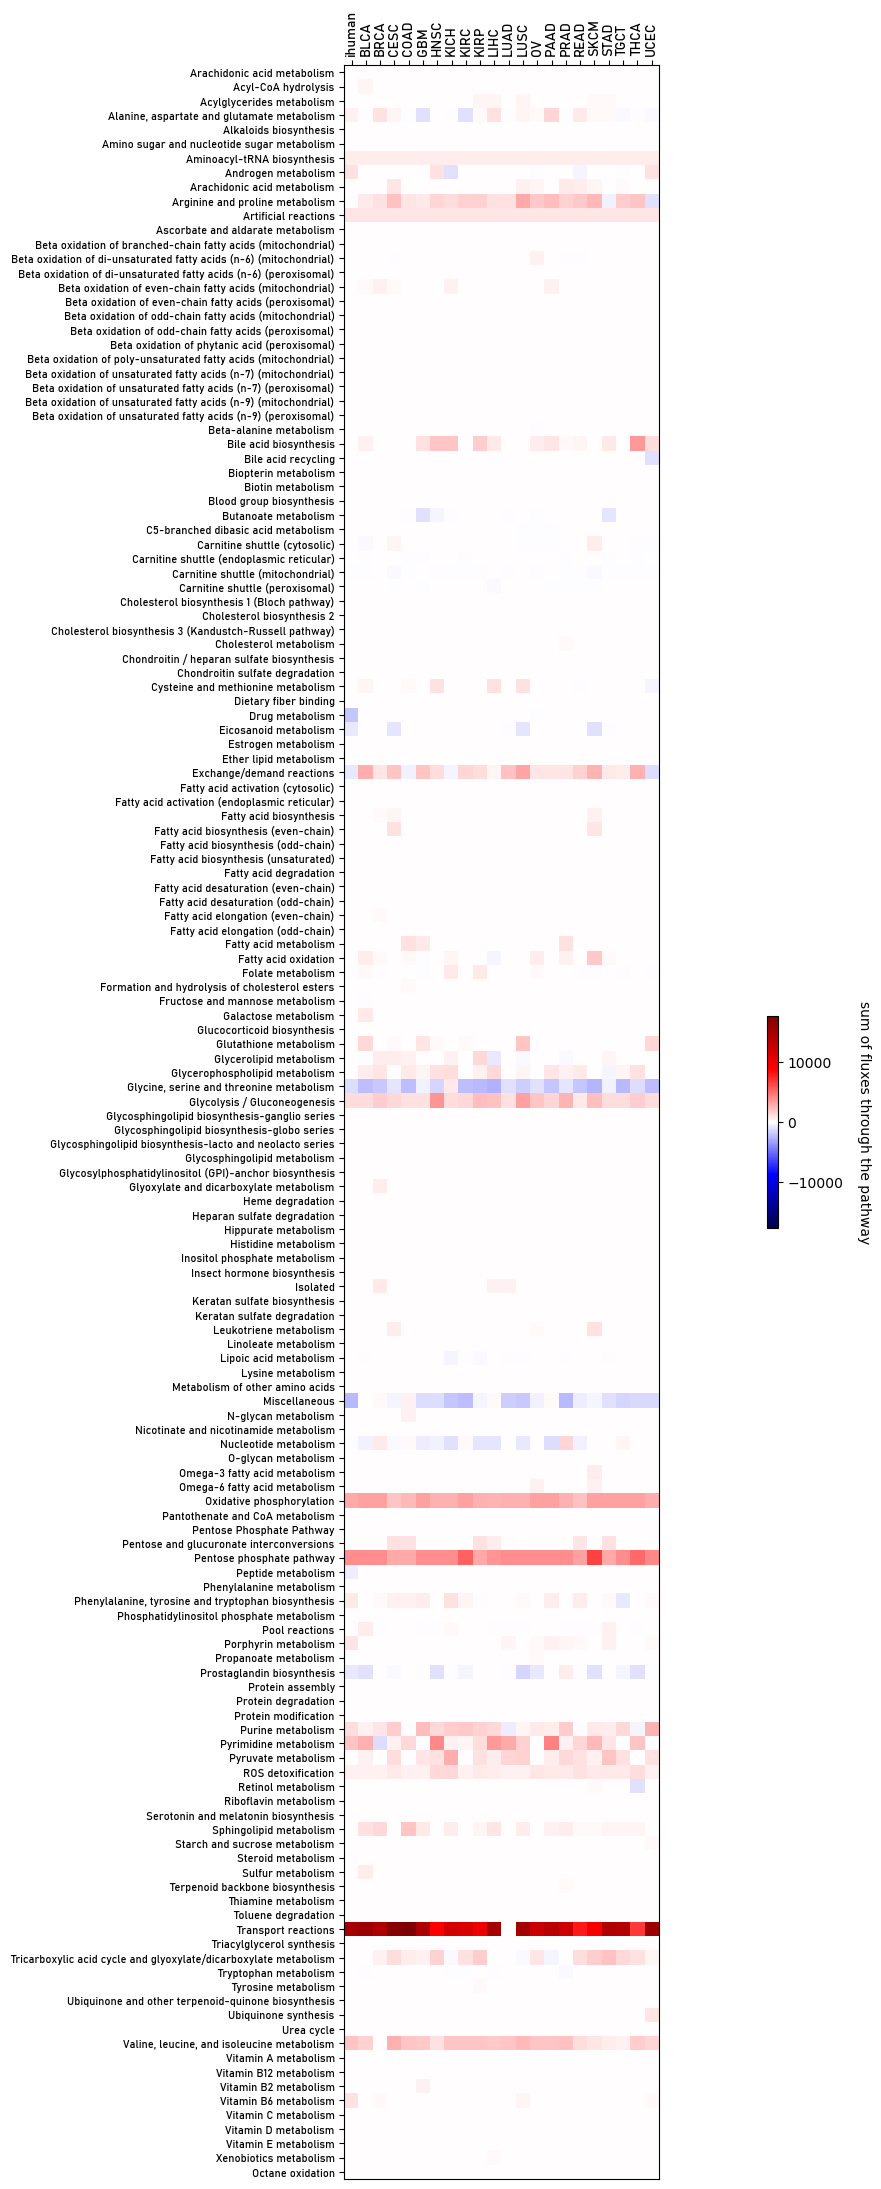

In [ ]:
# visualizing the fluxes as a heatmap
heatmap(pathway_fluxes_df.to_numpy(), models.keys(), pathways_corr, 'sum of fluxes through the pathway', symmetric_scale=True, colortype="seismic", save_as="./outputs/ftINIT_models_pathway_abs_flux.png")

C:\Users\phili\AppData\Local\Temp\ipykernel_18244\946866051.py:5: RuntimeWarning: divide by zero encountered in log10
  pathway_fluxes_poslog = np.where(pathway_fluxes_df.to_numpy() > 10, np.log10(abs(pathway_fluxes_df.to_numpy())), pathway_fluxes_df.to_numpy())
C:\Users\phili\AppData\Local\Temp\ipykernel_18244\946866051.py:6: RuntimeWarning: divide by zero encountered in log10
  pathway_fluxes_neglog = np.where(pathway_fluxes_df.to_numpy() < -10, ((-1)*(np.log10(abs(pathway_fluxes_df.to_numpy())))), pathway_fluxes_poslog)


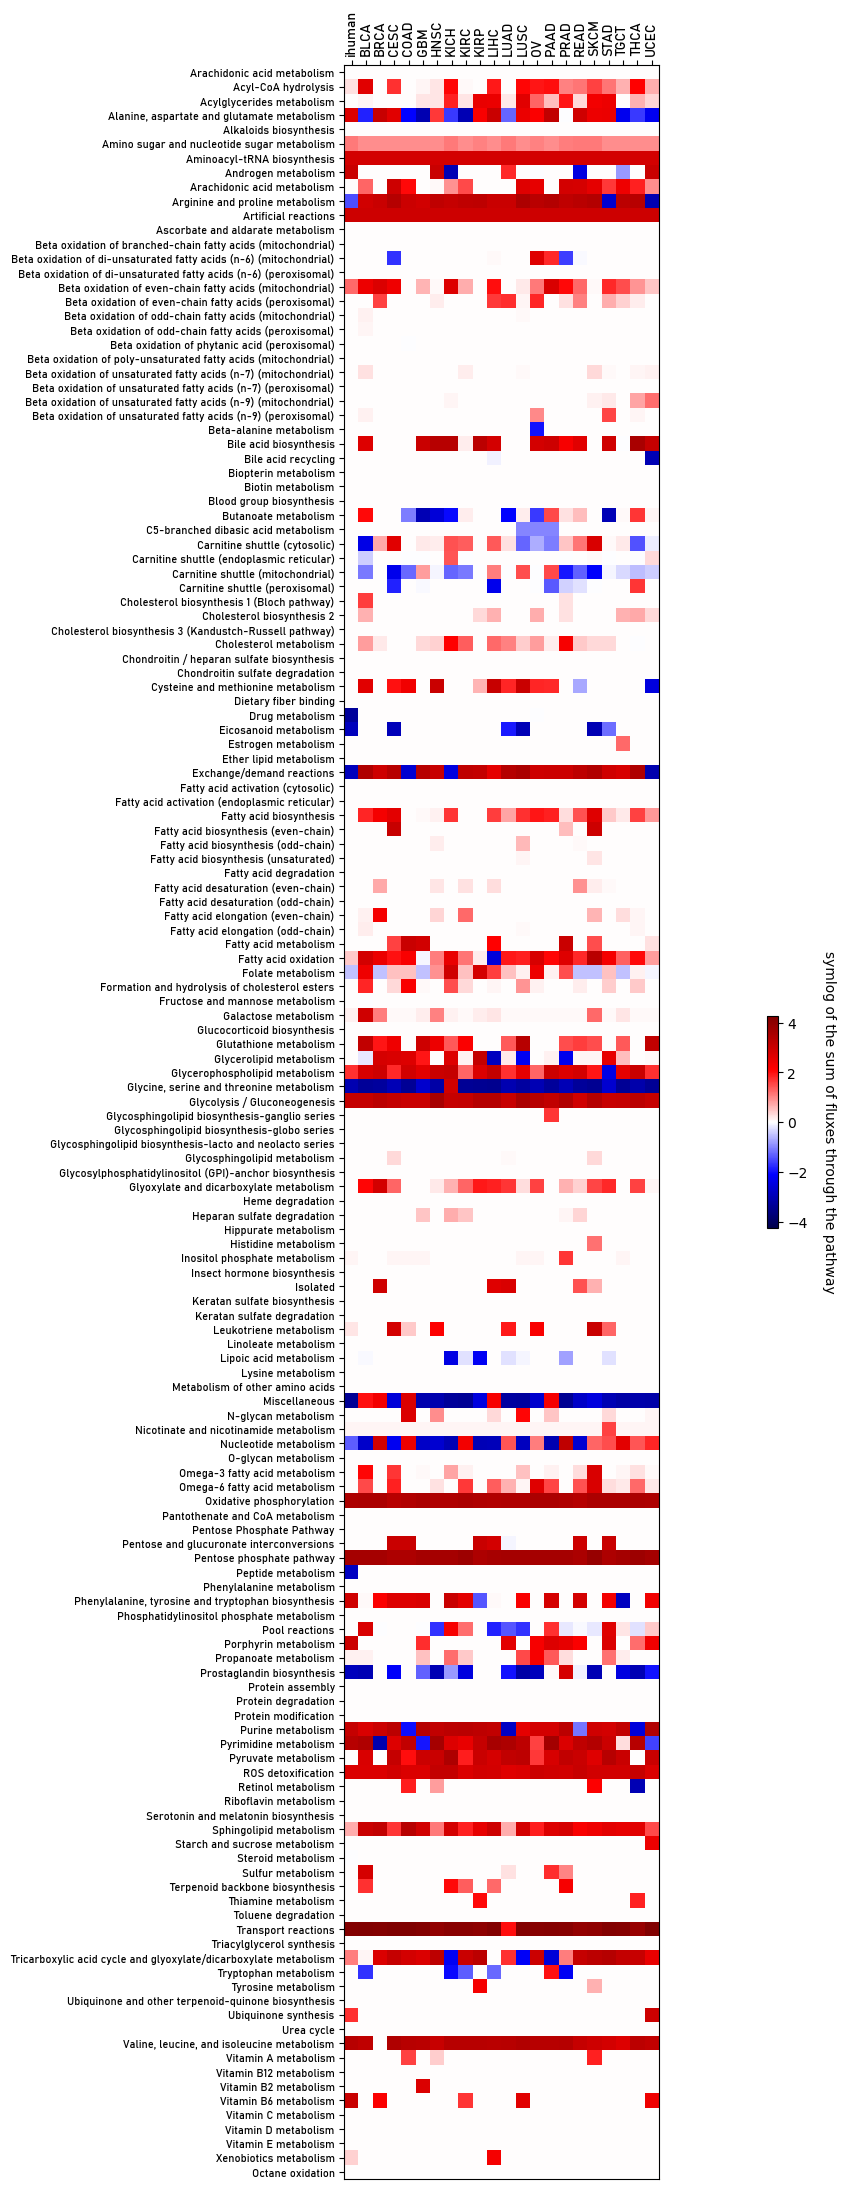

In [ ]:
# differences in smaller values are hard to see in the heatmap above

# transforming the data so that values over 10 and the absolutes of the ones lower than -10 are logarithmized, 
# while the values between -10 and 10 remain linear normalized to the range between 1- and 1
pathway_fluxes_poslog = np.where(pathway_fluxes_df.to_numpy() > 10, np.log10(abs(pathway_fluxes_df.to_numpy())), pathway_fluxes_df.to_numpy())
pathway_fluxes_neglog = np.where(pathway_fluxes_df.to_numpy() < -10, ((-1)*(np.log10(abs(pathway_fluxes_df.to_numpy())))), pathway_fluxes_poslog)
pathway_fluxes_symlog = np.where((pathway_fluxes_df.to_numpy() >= -10) & (pathway_fluxes_df.to_numpy() <= 10), (pathway_fluxes_df.to_numpy()/10), pathway_fluxes_neglog)

# visualizing transformed data as a heatmap
heatmap(pathway_fluxes_symlog, models.keys(), pathways_corr, 'symlog of the sum of fluxes through the pathway', symmetric_scale=True, colortype="seismic", save_as="./outputs/ftINIT_models_pathway_log_flux.png")

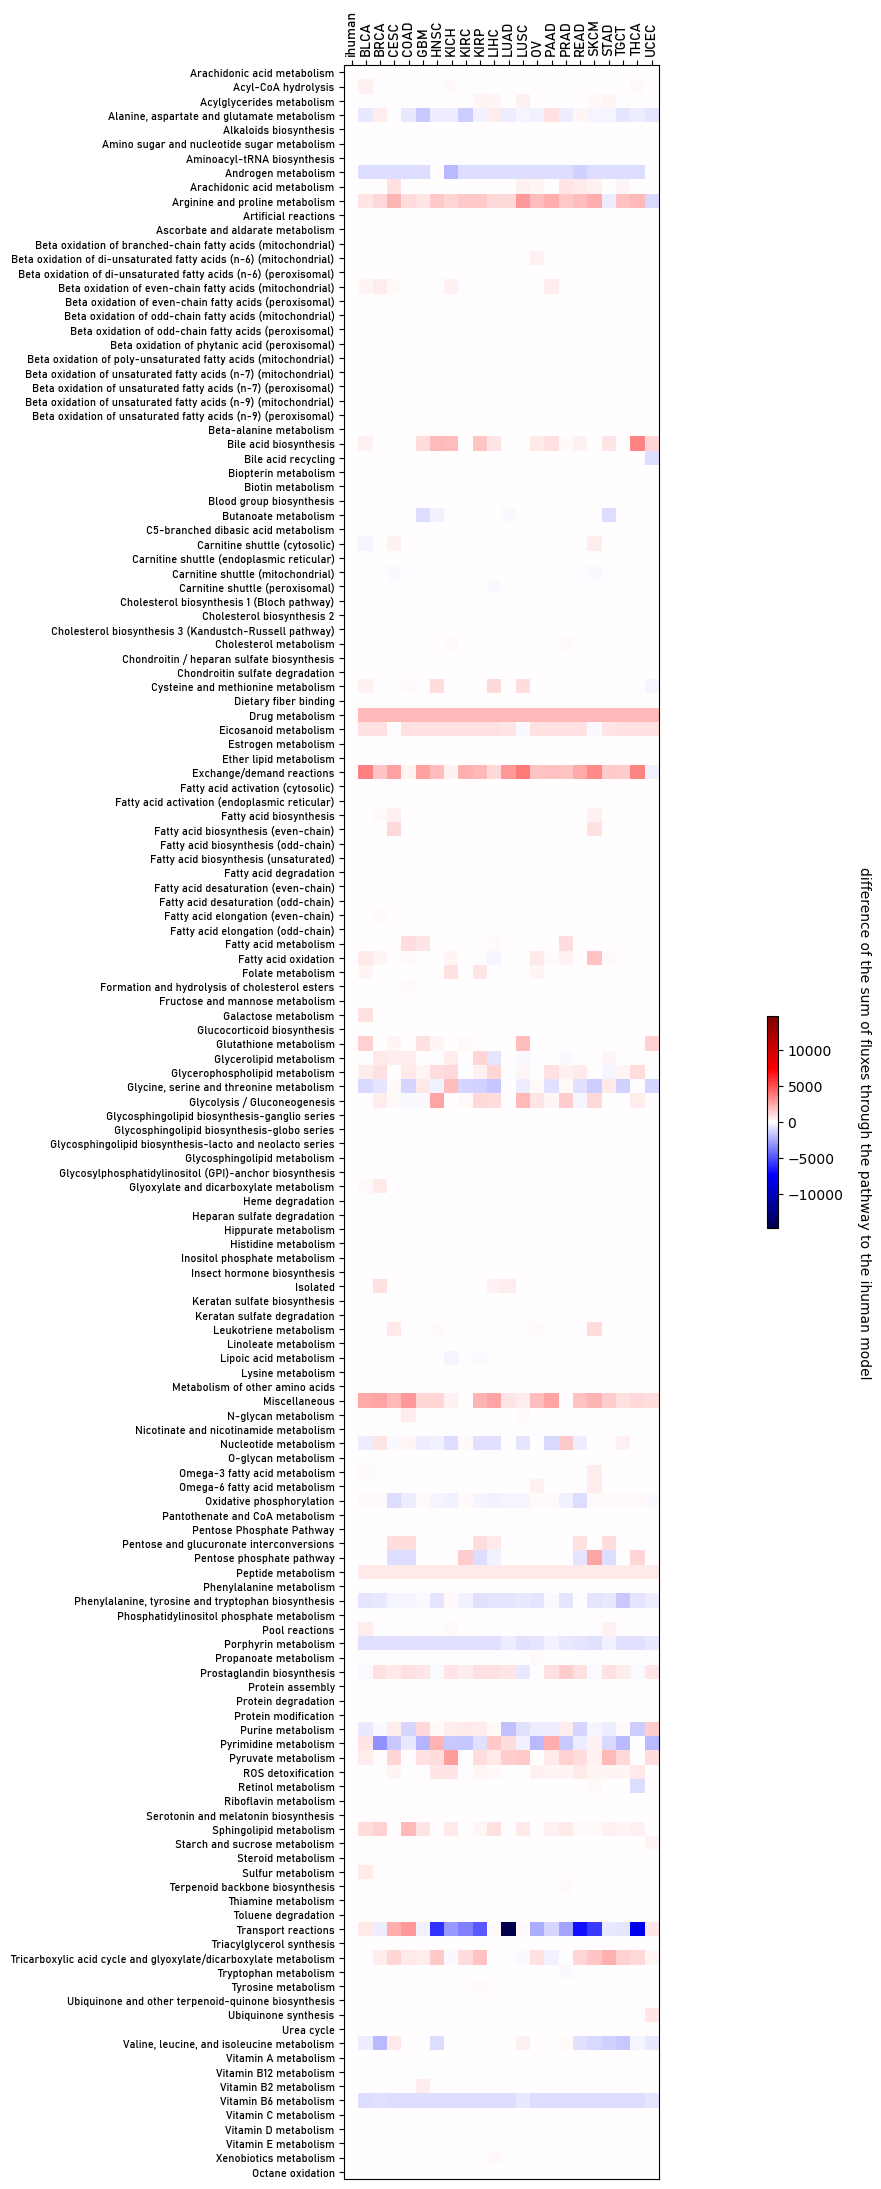

In [212]:
# making a heatmap of flux changes to the human model
pathway_fluxes_np = pathway_fluxes_df.to_numpy()
pathway_flux_dif = (pathway_fluxes_np - pathway_fluxes_np[:,[0]])

heatmap(pathway_flux_dif, models.keys(), pathways_corr, 'difference of the sum of fluxes through the pathway to the ihuman model', symmetric_scale=True, colortype="seismic", save_as="./outputs/ftINIT_models_pathway_differences.png")

# Calculating individual fluxes

In [215]:
# creating an empty dictionary of lists for the flux values
reaction_fluxes = {}
for model in models.keys():
    reaction_fluxes[model] = []

rxns = models["ihuman"].reactions
rxn_ids = {}
for rxn in rxns:
    rxn_ids[rxn.id] = rxn

# filling in the flux values for all reactions
for id in rxn_ids:
    for model in models:
        if rxn_ids[id] in models[model].reactions:
            reaction_fluxes[model].append(FBA_solutions[model].fluxes[id])
        else:
            reaction_fluxes[model].append(0)


# creating a pandas dataframe out of the dictionary
reaction_fluxes_df = pd.DataFrame(reaction_fluxes, index=rxn_ids.keys())
reaction_fluxes_df.to_csv("./outputs/ftINIT_models_reaction_fluxes.tsv", sep="\t")
reaction_fluxes_df

,ihuman,BLCA,BRCA,CESC,COAD,GBM,HNSC,KICH,KIRC,KIRP,...,LUSC,OV,PAAD,PRAD,READ,SKCM,STAD,TGCT,THCA,UCEC
MAR03905,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR03907,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR04097,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR04099,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR04108,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20168,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR20169,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR20170,0.00000,9.642266,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.037844,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.017163
MAR20171,1.42483,0.000000,0.000000,51.466719,0.0,0.000000,0.0,0.000000,0.222333,0.0,...,0.0,84.866696,37.778312,2.481928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Clusterung

In [ ]:
# Transpose the data so models are rows
flux_data_T = reaction_fluxes_df.T

In [ ]:
from sklearn.cluster import KMeans

# Perform clustering on models
n_clusters = 5  # Random number of clusters 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
model_clusters = kmeans.fit_predict(flux_data_T)

c:\Users\phili\anaconda3\envs\context_GEM\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


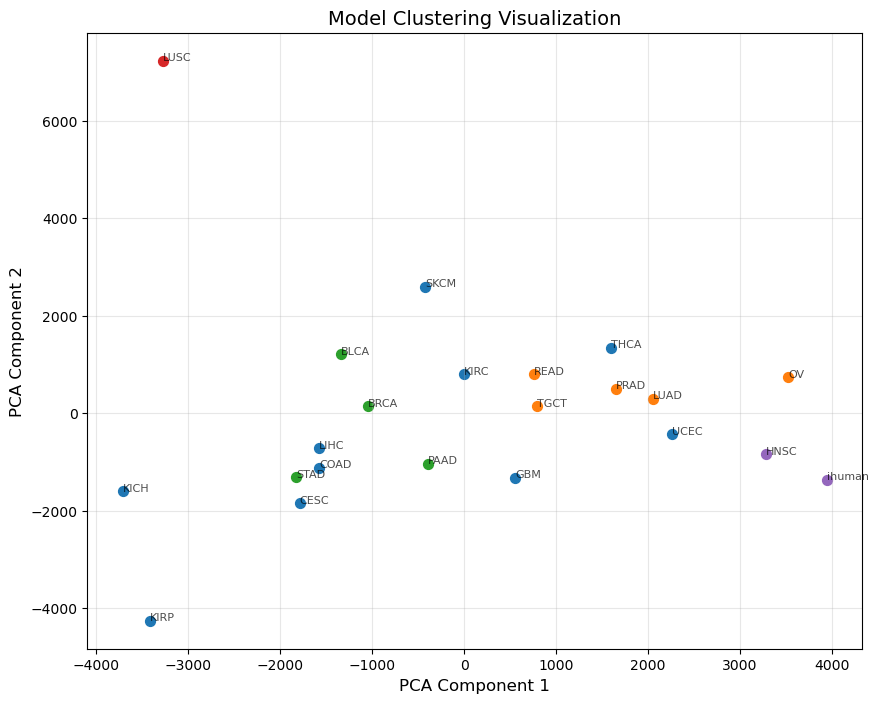

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
models_pca = pca.fit_transform(flux_data_T)

# Scatter plot with cluster labels
plt.figure(figsize=(10, 8))

# Plot each model as a point
for i, label in enumerate(flux_data_T.index):  # Use the transposed data's index (model names)
    plt.scatter(models_pca[i, 0], models_pca[i, 1], c=f'C{model_clusters[i]}', s=50, label=f'Cluster {model_clusters[i]}' if i == 0 else None)
    plt.text(models_pca[i, 0] + 0.02, models_pca[i, 1] + 0.02, label, fontsize=8, alpha=0.7)

# Plot decorations
plt.title('Model Clustering Visualization', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [273]:
# Get loadings (components)
loadings = pd.DataFrame(pca.components_.T, index=reaction_fluxes_df.index, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print(f"PC1 explains {pca.explained_variance_ratio_[0]} of the variance.")
print(f"Reaction {loadings["PC1"].idxmax()} has the biggest impact on the component ({loadings["PC1"].max()})")
print(models["ihuman"].reactions.get_by_id(loadings["PC1"].idxmax()).name)
print()
print(f"PC2 explains {pca.explained_variance_ratio_[1]} of the variance.")
print(f"Reaction {loadings["PC2"].idxmax()} has the biggest impact on the component ({loadings["PC2"].max()})")
print(models["ihuman"].reactions.get_by_id(loadings["PC2"].idxmax()).reaction)


PC1 explains 0.09315072943594212 of the variance.
Reaction MAR10363 has the biggest impact on the component (0.23364232782110042)
Transport of Methylmalonate, Antiport with Sulphite

PC2 explains 0.08606451667722079 of the variance.
Reaction MAR04922 has the biggest impact on the component (0.1213318715738388)
MAM01596c <=> MAM01596m


In [251]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(flux_data_T, model_clusters)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.004834560485707528
